**Общая информация**

**Срок сдачи:** 20 марта 2019, 06:00 <br\>
**Штраф за опоздание:** -1 балл после 06:00 20 марта, -2 балла после 06:00 27 марта, -3 балла после 06:00 3 апреля

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack скинуть ссылку в личный чат @alkhamush
Пример ссылки:
https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb 


Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (2 баллов)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

###### Задание 2 (2 балла)
Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy

###### Задание 3 (2 балла)
Для iris найдите такой параметр n_neighbors, при котором выдаётся наилучший score. Нарисуйте график зависимости score от n_neighbors

###### Задание 4 (3 балла)
Добавить algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Значение n_neighbors нужно взять из задания 3. Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

###### Задание 5 (1 балла)
Описать для чего нужны следующие библиотеки/классы/функции (список будет ниже)

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять структуру кода и текст. В противном случае -1 балл


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pylab
import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KDTree
from mlxtend.data import loadlocal_mnist

#%load_ext pycodestyle_magic

In [3]:
#%%pycodestyle

class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin, ClassifierMixin):
    
    def __init__(self, n_neighbors=5, weights='uniform', algorithm='brute',
                 metric='minkowski', p=2):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.algorithm = algorithm
        self.metric = metric
        self.m_p = p  
        
    def fit(self, X, y):
        self.data = X 
        self.target = y
        self.n_classes = len(np.unique(y))
        return self
    
    def distance(self, t):
        return (np.sum((self.data - t) ** self.m_p, axis = 1)) ** (1 / self.m_p) 
    
    def euclidean_distance(self, t):
        return np.sqrt(np.sum((self.data - t) ** 2, axis = 1))
    
    def find_class_brute(self, t):
        mas = self.distance(t)
        a = mas.argsort()[:self.n_neighbors]
        imp = np.zeros(self.n_classes)
        ans = -1
        for i in range(self.n_neighbors):
            if mas[int(a[i])] == 0: 
                ans = self.target[a[i]]
                break
            imp[int(self.target[int(a[i])])] += (1 / mas[int(a[i])])
        if ans == -1:
            ans = np.argmax(imp)
        return ans

    def find_class_kd_tree(self, X):
        tree = KDTree(self.data, leaf_size = self.n_neighbors)
        mas, ind = tree.query(X, k = self.n_neighbors)
        ans = np.zeros(len(X)) - 1
        for i in range(len(X)):
            imp = np.zeros(self.n_classes)
            for j in range(self.n_neighbors):
                if mas[i][j] == 0: 
                    ans[i] = self.target[ind[i][j]]
                    break
                imp[int(self.target[ind[i][j]])] += (1 / mas[i][j])
            if ans[i] == -1:
                ans[i] = int(imp.argmax())
        return ans        
    
    def predict(self, X):
        if self.algorithm == 'brute':
            ans = np.zeros(len(X))
            for i in range(len(X)):
                ans[i] = int(self.find_class_brute(X[i]))          
            return ans  
        if self.algorithm == 'kd_tree':
            return self.find_class_kd_tree(X)
    
    def predict_proba(self, X):
        W = np.zeros(shape = (len(X), self.n_classes))
        if self.algorithm == 'brute':
            j = 0
            for t in X:
                mas = self.distance(t)
                a = mas.argsort()[:self.n_neighbors]
                for i in range(self.n_neighbors):
                    W[j][self.target[int(a[i])]] += 1
                W[j] /= self.n_neighbors
                j += 1
            
        if self.algorithm == 'kd_tree':
            tree = KDTree(self.data, leaf_size = self.n_neighbors)
            mas, ind = tree.query(X, k = self.n_neighbors)
            for j in range(len(X)):
                for i in range(self.n_neighbors):
                    W[j][self.target[int(ind[j][i])]] += 1
                W[j] /= self.n_neighbors
        return W
    
    def score(self, X, y):
        a = self.predict(X)
        sc = 0 
        i = 0
        for p in a:
            if int(p) == int(y[i]):
                sc += 1
            i += 1    
        sc=sc / int(len(X))
        return sc      

**IRIS**

In [4]:
iris = datasets.load_iris()


In [5]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [6]:
clf = KNeighborsClassifier(n_neighbors=2)
my_clf = MyKNeighborsClassifier(n_neighbors=2)

In [7]:
%time clf.fit(X_train, y_train)

Wall time: 1e+03 µs


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [8]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


MyKNeighborsClassifier(algorithm='brute', metric='minkowski', n_neighbors=2,
            p=None, weights='uniform')

In [9]:
%time clf.predict(X_test)

Wall time: 2 ms


array([0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 0, 0, 1, 2, 1])

In [10]:
%time my_clf.predict(X_test)

Wall time: 2 ms


array([0., 0., 0., 1., 1., 2., 2., 2., 2., 2., 0., 0., 1., 2., 1.])

In [11]:
%time clf.predict_proba(X_test)

Wall time: 1e+03 µs


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [12]:
%time my_clf.predict_proba(X_test)

Wall time: 2 ms


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [13]:
clf.score(X_test, y_test)

0.9333333333333333

In [14]:
my_clf.score(X_test, y_test)

0.9333333333333333

Задание 3

The best score for n = 12


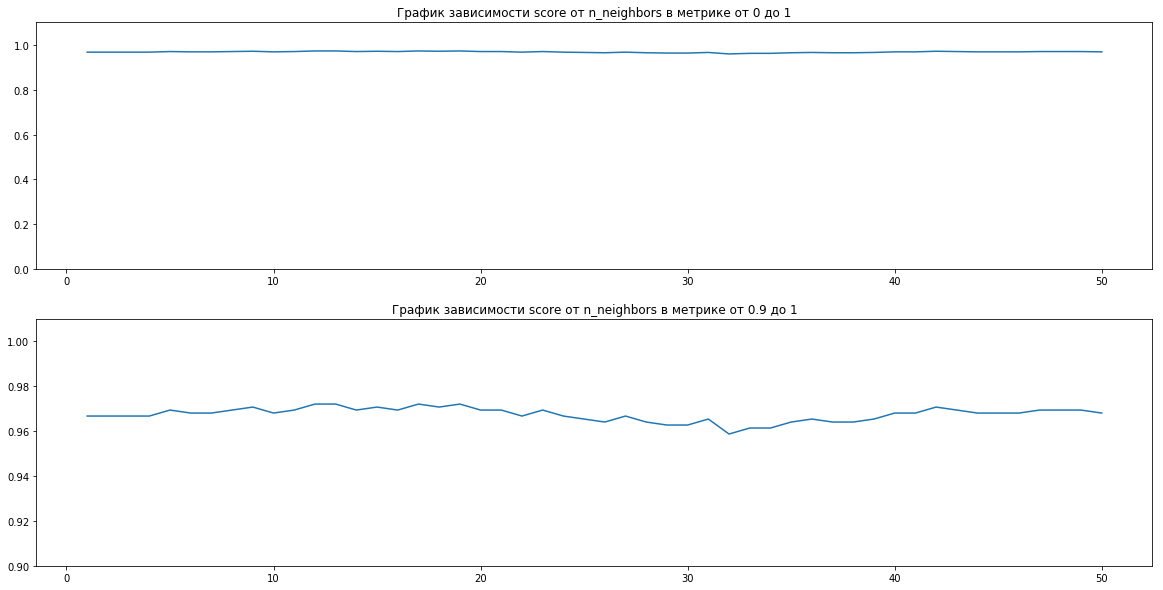

In [15]:
iris = datasets.load_iris()
x = np.arange(1, 51)
y = np.zeros(shape=50)
for j in range(50):
    X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, 
    stratify=iris.target)
    for i in range(1, 51):
        my_clf = MyKNeighborsClassifier(n_neighbors = i)
        my_clf.data = X_train
        my_clf.target = y_train
        my_clf.n_classes = len(np.unique(y_train))
        y[i-1] += my_clf.score(X_test, y_test)
y = y / 50        
t = x[y.argmax()]
print('The best score for n = ' + str(t))
fig = pylab.figure(figsize = (20, 10))
ax = fig.add_subplot(211) 
ax.plot(x, y)
pylab.ylim(0, 1.1)
ax.set_title('График зависимости score от n_neighbors в метрике от 0 до 1')

ax1 = fig.add_subplot(212)
ax1.plot(x, y)
pylab.ylim(0.9, 1.01)
ax1.set_title('График зависимости score от n_neighbors в метрике от 0.9 до 1')

pylab.show()



**MNIST**

In [16]:
X, y = loadlocal_mnist(
        images_path='train-images.idx3-ubyte', 
        labels_path='train-labels.idx1-ubyte')

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, stratify=y)

In [29]:
clf = KNeighborsClassifier(n_neighbors = 12)
my_clf = MyKNeighborsClassifier(n_neighbors = 12)

In [30]:
%time clf.fit(X_train, y_train)

Wall time: 58.9 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=12, p=2,
           weights='uniform')

In [31]:
%time my_clf.fit(X_train, y_train)

Wall time: 2 ms


MyKNeighborsClassifier(algorithm='brute', metric='minkowski', n_neighbors=12,
            p=None, weights='uniform')

In [32]:
%time clf.predict(X_test)

Wall time: 57 s


array([9, 3, 9, 6, 6, 9, 3, 8, 9, 9, 2, 3, 1, 5, 9, 0, 0, 9, 2, 3, 5, 9,
       5, 2, 2, 3, 0, 1, 1, 7, 1, 7, 5, 5, 5, 4, 4, 1, 7, 1, 5, 4, 9, 0,
       6, 7, 6, 4, 2, 7, 5, 6, 2, 1, 1, 2, 2, 1, 9, 0, 8, 2, 7, 4, 3, 4,
       3, 0, 2, 2, 2, 2, 7, 0, 1, 0, 7, 5, 5, 9, 1, 7, 1, 5, 7, 1, 8, 9,
       6, 6, 6, 8, 7, 0, 4, 8, 8, 5, 3, 1, 0, 8, 1, 1, 2, 6, 1, 3, 9, 0,
       5, 6, 7, 1, 3, 7, 7, 6, 3, 3, 5, 5, 4, 2, 8, 0, 0, 5, 3, 5, 4, 0,
       7, 3, 9, 3, 7, 7, 4, 1, 4, 6, 7, 8, 2, 6, 1, 1, 0, 7, 3, 3, 0, 0,
       9, 3, 3, 5, 6, 1, 7, 2, 4, 8, 5, 5, 4, 6, 6, 4, 0, 5, 0, 5, 7, 4,
       9, 6, 4, 9, 8, 5, 4, 1, 3, 6, 5, 7, 8, 0, 1, 3, 5, 3, 3, 0, 8, 4,
       9, 6, 3, 8, 0, 3, 7, 7, 3, 3, 6, 0, 1, 4, 7, 4, 8, 2, 8, 8, 9, 1,
       9, 0, 2, 0, 2, 7, 3, 1, 7, 1, 1, 0, 9, 8, 9, 1, 6, 8, 6, 8, 9, 6,
       4, 4, 7, 1, 1, 1, 4, 8, 6, 1, 9, 9, 0, 4, 6, 1, 8, 1, 3, 6, 0, 6,
       9, 6, 4, 7, 3, 2, 1, 3, 5, 7, 0, 4, 7, 1, 6, 6, 6, 4, 1, 7, 1, 4,
       9, 4, 6, 4, 8, 9, 0, 4, 7, 0, 0, 8, 6, 3, 0,

In [33]:
%time my_clf.predict(X_test)

Wall time: 1min 44s


array([4., 1., 1., 1., 0., 1., 1., 1., 1., 4., 1., 1., 1., 6., 7., 0., 1.,
       4., 1., 4., 1., 9., 7., 2., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 4., 7., 1., 7., 7., 4., 7., 1., 0., 1., 7., 0., 1., 1., 1., 1.,
       2., 4., 1., 1., 7., 1., 1., 0., 0., 1., 1., 7., 0., 1., 7., 0., 1.,
       4., 1., 3., 4., 1., 1., 1., 1., 0., 1., 1., 4., 1., 7., 1., 1., 1.,
       1., 1., 7., 6., 1., 1., 1., 7., 1., 1., 1., 4., 5., 1., 1., 0., 3.,
       1., 1., 2., 6., 1., 1., 1., 0., 3., 1., 7., 1., 1., 1., 1., 6., 3.,
       1., 5., 5., 1., 4., 3., 9., 0., 1., 1., 1., 1., 7., 1., 4., 1., 3.,
       7., 1., 1., 1., 7., 4., 1., 5., 3., 1., 1., 1., 0., 1., 1., 1., 0.,
       1., 1., 1., 8., 1., 1., 1., 1., 2., 1., 1., 1., 7., 1., 0., 1., 0.,
       0., 1., 1., 4., 0., 1., 4., 1., 4., 0., 3., 1., 4., 3., 1., 1., 1.,
       7., 1., 1., 1., 3., 1., 1., 4., 1., 1., 1., 1., 3., 1., 3., 7., 0.,
       1., 7., 1., 6., 1., 4., 1., 4., 1., 1., 1., 0., 1., 4., 1., 1., 7.,
       1., 7., 1., 2., 1.

In [24]:
%time clf.predict_proba(X_test)

Wall time: 47.8 s


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.26666667, 0.        , ..., 0.73333333, 0.        ,
        0.        ]])

In [28]:
%time my_clf.predict_proba(X_test)

Wall time: 2min 18s


array([[0.13333333, 0.06666667, 0.        , ..., 0.2       , 0.        ,
        0.06666667],
       [0.        , 0.53333333, 0.06666667, ..., 0.26666667, 0.        ,
        0.        ],
       [0.        , 0.66666667, 0.        , ..., 0.13333333, 0.        ,
        0.06666667],
       ...,
       [0.        , 0.66666667, 0.        , ..., 0.13333333, 0.        ,
        0.13333333],
       [0.2       , 0.73333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.8       , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [26]:
clf.score(X_test, y_test)

0.98

In [34]:
my_clf.score(X_test, y_test)

0.295

Задание 4

In [35]:
clf = KNeighborsClassifier(n_neighbors=10, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=10, algorithm='kd_tree')

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, stratify=y)

In [37]:
%time clf.fit(X_train, y_train)

MemoryError: 

In [38]:
%time my_clf.fit(X_train, y_train)

Wall time: 4 ms


MyKNeighborsClassifier(algorithm='kd_tree', metric='minkowski',
            n_neighbors=10, p=None, weights='uniform')

In [39]:
%time clf.predict(X_test)

AttributeError: 'KNeighborsClassifier' object has no attribute '_tree'

In [40]:
%time my_clf.predict(X_test)

MemoryError: 

In [95]:
%time clf.predict_proba(X_test)

Wall time: 1e+03 µs


array([[0. , 0.1, 0.9],
       [0. , 0.5, 0.5],
       [0. , 1. , 0. ],
       [0. , 0.2, 0.8],
       [0. , 0.1, 0.9],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ]])

In [87]:
%time my_clf.predict_proba(X_test)

Wall time: 2 ms


array([[0. , 0.1, 0.9],
       [0. , 0.5, 0.5],
       [0. , 1. , 0. ],
       [0. , 0.2, 0.8],
       [0. , 0.1, 0.9],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ]])

In [88]:
clf.score(X_test, y_test)

0.8

In [89]:
my_clf.score(X_test, y_test)

0.9333333333333333

Задание 5

In [ ]:
# seaborn
# это библиотека Python, основанная на Matplotlib, созданная для визуализации данных.
# Он обеспечивает интерфейс высокого уровня для рисования привлекательной и информативной статистической графики.

# matplotlib
# библиотека на языке программирования Python для визуализации данных двумерной графикой.
# Библиотека Matplotlib построена на принципах ООП, но имеет процедурный интерфейс pylab, который я использовал в своей работе.

# train_test_split
# утилита, которая разбивает массивы и матрицы на случайные последовательности.

# Pipelin%load_ext e (from sklearn.pipeline import Pipeline)
# 
,
# StandardScaler (from sklearn.preprocessing import StandardScaler)
# Метод,осуществляющий стандартизацию объектов путем удаления среднего и масштабирования до единичной дисперсии.

# ClassifierMixin
# Mixin класс для всех классификаторо в sklearn. Mixin - это особой тип множественного наследования.

# NeighborsBase
# Базовый класс для оценок ближайших соседей.

# KNeighborsMixin
# метод, используемый для поиска ближайших соседей.

# SupervisedIntegerMixin
# проверяет параметры, выполняет операцию проверки типа, а затем вызывает _fit метода NeighborsBass
